# Import

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from signSGD import signSGD
from NadamAngles import Nadam
from AdamAngles import Adam

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from collections import namedtuple
import pickle
import string

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Classes

In [3]:
class RNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, n_layers, output_size, LSTM=False):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers
        self.output_size = output_size
        self.LSTM = LSTM
        
        self.encoder = nn.Embedding(output_size, embedding_size)
        if LSTM:
            self.cell = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        else:
            self.cell = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_):
        batch_size = input_.shape[0]
        sentence_size = input_.shape[1]
        
        input_ = self.encoder(input_)
        outputs = self.cell(input_)[0]
        outputs = self.decoder(outputs)
        return outputs
            
    def pred(self, input_, hidden):
        input_ = self.encoder(input_)
        if self.LSTM:
            output, hidden = self.cell(input_.view(1, 1, -1), (hidden[0], hidden[1]))
        else:
            output, hidden = self.cell(input_.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size).to(device)

# Functions

In [4]:
def train(model, inputs, optimizer, criterion, batch_size_characters, batch_size_sentences, losses, nb_epoch, vocabulary_length):    
    for epoch in range(nb_epoch):
        batches = DataLoader(range(len(inputs)), batch_size=batch_size_sentences, shuffle=True)
        for i, batch_indices in enumerate(batches):
            optimizer.zero_grad()

            batch = inputs[batch_indices]

            target = batch[:, 1:].reshape(-1)
            batch = batch[:, :-1]

            output = model(batch).reshape(-1, vocabulary_length)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        
        if epoch % 1 == 0:
            print(f"Epoch: {epoch}")
            print(f"Loss: {loss}")
            print()
    return losses

In [5]:
def chars_to_ints(data_str, all_characters):
    return list(map(lambda c: all_characters.index(c), data_str))

In [6]:
def words_to_ints(data_str, vocabulary):
    data_int = []
    for w in data_str:
        data_int.append(vocabulary[w])
    return data_int

In [7]:
def create_training_instances(optimizers, original_model):
    training_instances = {}
    for name, (optimizer, kwargs) in optimizers.items():
        curr_rnn = RNN(original_model.embedding_size, original_model.hidden_size, original_model.n_layers,\
                       original_model.output_size, original_model.LSTM).to(device)
        curr_rnn.load_state_dict(original_model.state_dict())
        optimizer = optimizer(curr_rnn.named_parameters(), **kwargs)
        training_instances[name] = training_instance(optimizer=optimizer, model=curr_rnn, losses=[])
    return training_instances, optimizer

In [8]:
def moving_avg(x, n):
    return np.convolve(np.array(x), np.ones((n,))/n, mode='valid')

def plot_mv_avg(l, title, labels, end=None, semilogy=False, n=1):
    ax = plt.figure(figsize=(10,8))
    plot = plt.semilogy if semilogy else plt.plot
    for l_sub in l:
        l_sub = l_sub[:end] if end else l_sub
        l_avg = moving_avg(l_sub, min(n,len(l_sub)))
        x = range(len(l_avg))
        plot(x, l_avg)
    ax.legend(labels)
    plt.xlabel('Batch')
    plt.ylabel('Moving average')
    plt.title(title)
    plt.show()

In [9]:
def save_training_instances(training_instances, prefix_name=None):
    for name, training_instance in training_instances.items():
        torch.save(training_instance.model.state_dict, f'trained_data/model_{prefix_name + "_" if prefix_name else ""}{name}')
        with open(f'trained_data/losses_{prefix_name + "_" if prefix_name else ""}{name}.pickle', 'wb') as f:
            pickle.dump(training_instance.losses, f)

In [10]:
def load_training_instances(optimizers_name, *network_params, prefix_name=None):
    training_instances = {}
    for optimizer_name in optimizers_name:
        rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM).to(device) 
        rnn.load_state_dict(torch.load(f'trained_data/model_{prefix_name + "_" if prefix_name else ""}{optimizer_name}')())
        print(f'Loaded: trained_data/model_{prefix_name + "_" if prefix_name else ""}{optimizer_name}')
        with open(f'trained_data/losses_{prefix_name + "_" if prefix_name else ""}{optimizer_name}.pickle', 'rb') as f:
            losses = pickle.load(f)
        training_instances[optimizer_name] = training_instance(optimizer=None, model=rnn, losses=losses)
        print(f'Loaded: trained_data/losses_{prefix_name + "_" if prefix_name else ""}{optimizer_name}.pickle')
    return training_instances

# Load data

## Shakespeare

In [11]:
with open('data/shakespeare.txt') as f:
    shakespeare = f.read()

In [12]:
all_characters = string.printable
data_shake = chars_to_ints(shakespeare, all_characters)

## Wikitext2

In [13]:
with open('data/wiki.train.tokens', encoding="utf8") as f:
    wikitext2 = f.read()
wikitext2 = wikitext2.split()
print(f'Text length: {len(wikitext2)} words')

Text length: 2051910 words


In [14]:
word_to_int = {}
for i, w in enumerate(set(wikitext2)):
    word_to_int[w] = i
print(f'Vocabulary length: {len(word_to_int.items())}')

Vocabulary length: 33277


In [15]:
int_to_word = dict((v,k) for k,v in word_to_int.items())

In [16]:
data_wiki = words_to_ints(wikitext2, word_to_int)

# Training

## Experiments for learning rates

### Adam

In [17]:
### PARAMETERS
np.random.seed(201) # Seed for parameters
torch.manual_seed(201)
nb_epoch = 2
embedding_size = 300 # Embedding size PER character
hidden_size = 300 # Hidden state size in cell
n_layers = 1 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 10 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {}
learning_rates = [1e-1]
for lr in learning_rates:
    optimizers['Adam' + '_' + str(lr)] = (Adam, {'lr':lr})
              
            
### COPY PASTE IN DICT ABOVE TO USE    
#'RMSprop':(torch.optim.RMSprop, {'lr':1e-3})
#'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.5})
#'signSGD':(signSGD, {'lr':1e-3})
#'Adam':(torch.optim.Adam, {'lr':1e-3})}
#'AdamW':(torch.optim.AdamW, 1e-3)
#'Nadam_QH':(QHAdam, {'lr':1e-3, 'nus':(0.999, 1.0), 'betas':(0.995, 0.999)})
#'RMSprop_QH':(QHAdam, {'lr':1e-3, 'nus':(0, 1.0), 'betas':(0.995, 0.999)})

training_instances, optimizer = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    np.random.seed(201)
    torch.manual_seed(201)
    train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

#### Optimizer: Adam_0.1 ####
Epoch: 0
Loss: 7.5930256843566895



RuntimeError: CUDA out of memory. Tried to allocate 230.00 MiB (GPU 0; 6.00 GiB total capacity; 3.56 GiB already allocated; 214.69 MiB free; 3.81 GiB reserved in total by PyTorch)

In [29]:
updates_step = optimizer.updates['cell.weight_hh_l0']
print(len(updates_step))
print(updates_step[0].shape)
tensor_out = torch.empty((1833, 1200, 300))
for i, tensor in enumerate(updates_step):
    tensor_out[i] = tensor.to('cpu')

1833
torch.Size([1200, 300])


In [44]:
products = tensor_out[2:] * tensor_out[1:-1]
angles = products.sum((1,2))
angles = angles / (torch.norm(tensor_out[2:], dim=(1,2)) * torch.norm(tensor_out[1:-1], dim=(1,2)))
angles = torch.acos(angles)

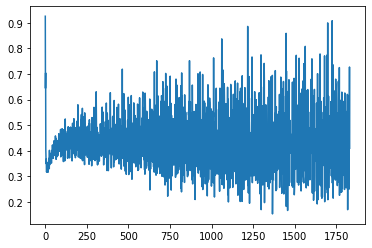

In [45]:
plt.plot(angles)

### Nadam

In [17]:
### PARAMETERS
np.random.seed(201) # Seed for parameters
torch.manual_seed(201)
nb_epoch = 2
embedding_size = 300 # Embedding size PER character
hidden_size = 300 # Hidden state size in cell
n_layers = 1 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 10 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {}
learning_rates = [5e-3]
for lr in learning_rates:
    optimizers['Nadam' + '_' + str(lr)] = (Nadam, {'lr':lr})
              
            
### COPY PASTE IN DICT ABOVE TO USE    
#'RMSprop':(torch.optim.RMSprop, {'lr':1e-3})
#'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.5})
#'signSGD':(signSGD, {'lr':1e-3})
#'Adam':(torch.optim.Adam, {'lr':1e-3})}
#'AdamW':(torch.optim.AdamW, 1e-3)
#'Nadam_QH':(QHAdam, {'lr':1e-3, 'nus':(0.999, 1.0), 'betas':(0.995, 0.999)})
#'RMSprop_QH':(QHAdam, {'lr':1e-3, 'nus':(0, 1.0), 'betas':(0.995, 0.999)})

training_instances, optimizer = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    np.random.seed(201)
    torch.manual_seed(201)
    train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

#### Optimizer: Nadam_0.005 ####
Epoch: 0
Loss: 5.685582160949707



RuntimeError: CUDA out of memory. Tried to allocate 230.00 MiB (GPU 0; 6.00 GiB total capacity; 3.79 GiB already allocated; 65.61 MiB free; 4.04 GiB reserved in total by PyTorch)

In [18]:
updates_step = optimizer.updates['cell.weight_hh_l0']
print(len(updates_step))
print(updates_step[0].shape)

2010
torch.Size([1200, 300])


In [19]:
tensor_out = torch.empty((2010, 1200, 300))
for i, tensor in enumerate(updates_step):
    tensor_out[i] = tensor.to('cpu')

In [20]:
products = tensor_out[2:] * tensor_out[1:-1]
angles = products.sum((1,2))
angles = angles / (torch.norm(tensor_out[2:], dim=(1,2)) * torch.norm(tensor_out[1:-1], dim=(1,2)))
angles = torch.acos(angles)

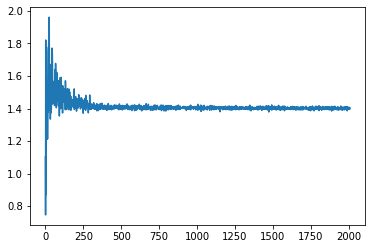

In [23]:
plt.plot(angles)